# Google Colab Lab Assignment -Pretrained Model

---



**Course Name:** Deep Learning Lab

**Lab Title:** Research Paper Implementation with Pre-trained Model (Deep Convolutional Neural Networks for Sign Language Recognition)

**Student Name:** Priyanka kadam

**Student ID:** 202201060018

**Date of Submission:** 20 February 2025

**Group Members**: Yathang Tupe and Aditi Kulkarni


---



**Research Paper Study and Implementation**

**Instructions:**

1. Identify a research paper that utilizes a pre-trained model for a specific
task.

2. Study the methodology, dataset, and model used in the research paper.

3. Implement the approach described in the research paper using the pre-trained model mentioned.

4. Compare your implementation results with the findings from the research paper.


**Objective**
1.   Study a research paper utilizing a pre-trained model.
2.   Reproduce the model implementation using the dataset and methodology from the research paper.
3.   Fine-tune the pre-trained model and optimize hyperparameters.
3.   Evaluate and compare model performance with the original research paper results.









**Task 1: Research Paper Selection and Dataset Preparation (2 hours)**

**Instructions:**

1. Select a research paper that applies a pre-trained model (e.g., VGG, ResNet, EfficientNet, etc.).

2. Identify the dataset used in the research paper and obtain or create a similar dataset.(**Mention Dataset Link and Description**)

3. Perform necessary preprocessing steps:

 Resize images to match the model input dimensions.

 Apply data augmentation techniques if applicable.

4. Split the dataset into training, validation, and testing sets.

Research Paper Link:- https://ieeexplore.ieee.org/abstract/document/8316344

Dataset Link:- https://www.kaggle.com/datasets/ayuraj/asl-dataset/code


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ayuraj/asl-dataset")

print("Path to dataset files:", path)

100%|██████████| 56.9M/56.9M [00:00<00:00, 64.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/ayuraj/asl-dataset/versions/1


In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
%matplotlib inline

Dataset contents: ['p', 'j', '3', 'f', '4', 'v', 'd', 'a', '1', 'h', 'y', 'c', 's', 'q', '7', 'x', 't', '2', '5', 'b', 'i', 'l', 'e', 'asl_dataset', 'k', 'u', '6', 'r', 'g', '0', 'n', '9', 'z', 'o', 'm', 'w', '8']
Total Images Found: 2515
                          img_names categories  \
0  hand1_p_right_seg_2_cropped.jpeg          p   
1  hand1_p_right_seg_3_cropped.jpeg          p   
2    hand2_p_dif_seg_5_cropped.jpeg          p   
3    hand2_p_top_seg_5_cropped.jpeg          p   
4    hand1_p_dif_seg_2_cropped.jpeg          p   

                                           img_paths  
0  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
1  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
2  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
3  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  
4  /root/.cache/kagglehub/datasets/ayuraj/asl-dat...  


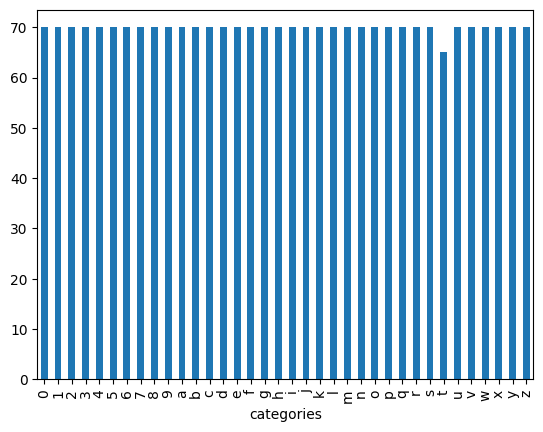

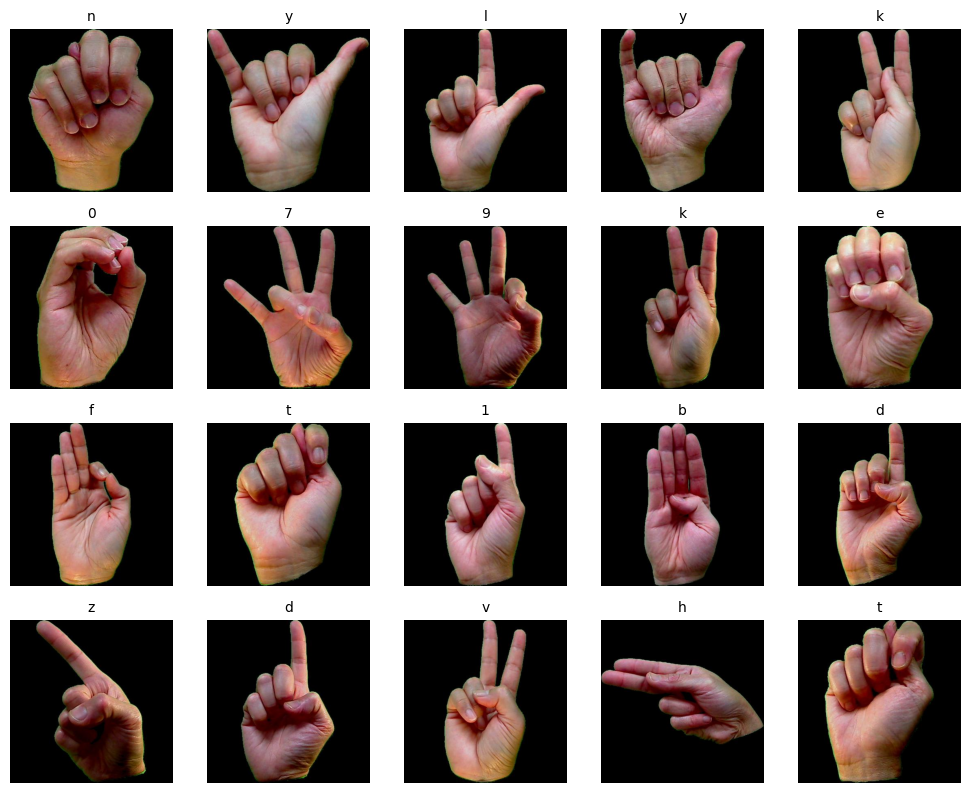

In [ ]:
# Get dataset root directory
dataset_path = os.path.join(path, "asl_dataset")  # Update this based on your dataset structure

# Verify dataset structure
print("Dataset contents:", os.listdir(dataset_path))

# Prepare DataFrame
img_df = pd.DataFrame(columns=["img_names", "categories", "img_paths"])
file_names = os.listdir(dataset_path)

# Remove system files
if ".DS_Store" in file_names:
    file_names.remove(".DS_Store")

# Collect image paths
img_list = []

for img_category in file_names:
    category_path = os.path.join(dataset_path, img_category)

    if os.path.isdir(category_path):  # Ensure it's a directory
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            if os.path.isfile(img_path):  # Only include image files
                img_list.append({"img_names": img_name, "categories": img_category, "img_paths": img_path})

# Convert to DataFrame
df = pd.DataFrame(img_list)

# Print DataFrame structure
print("Total Images Found:", df.shape[0])
print(df.head())
df["categories"].sort_values().value_counts(sort=False).plot(kind="bar");
# Plot example images
plt.figure(figsize=(10, 10))
for i in range(20):
    j = np.random.randint(df.shape[0])
    try:
        img = plt.imread(df["img_paths"].iloc[j])
        plt.subplot(5, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(df['categories'].iloc[j], fontsize=10)
    except Exception as e:
        print(f"Error loading image {df['img_paths'].iloc[j]}: {e}")

plt.tight_layout()
plt.show()


In [ ]:
X = df["img_paths"].values
Y = df["categories"]
lb = LabelEncoder()
Y_encode = lb.fit_transform(Y)
Y_encode = to_categorical(Y_encode)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_encode, test_size=0.25, random_state=42)
X_test, X_valid, Y_test, Y_valid = train_test_split(X_test, Y_test, test_size=.5, random_state=42)
X_train.shape, X_test.shape
input_h, input_w = 224, 224
x_test_arr = np.zeros((X_test.shape[0], input_h, input_w,  3))

for i in range(len(X_test)):

    im = load_img(X_test[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_test_arr[i] = img_to_array(im)/255

x_train_arr = np.zeros((X_train.shape[0], input_h, input_w,  3))

for i in range(len(X_train)):

    im = load_img(X_train[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_train_arr[i] = img_to_array(im)/255

x_valid_arr = np.zeros((X_valid.shape[0], input_h, input_w,  3))

for i in range(len(X_valid)):

    im = load_img(X_valid[i],
        color_mode="rgb",
        target_size=(input_h, input_w),
        interpolation="nearest",
        keep_aspect_ratio=False)
    x_valid_arr[i] = img_to_array(im)/255

x_train_arr.shape, x_test_arr.shape, x_valid_arr.shape
Y_valid.shape, Y_test.shape, Y_train.shape

((315, 36), (314, 36), (1886, 36))

In [ ]:
img_size = 224
batch_size = 64

# Define the dataset paths
train_path = os.path.join(dataset_path)  # Root contains labeled folders
valid_path = os.path.join(dataset_path)  # Same root structure

# Data generator for training
datagen_train = ImageDataGenerator(
    rescale=1./255,  # Normalize pixel values
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    validation_split=0.2
)
train_generator = datagen_train.flow_from_directory(train_path,
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True,
                                                    subset="training")  # Using training subset

# Data generator for validation
validation_generator = datagen_train.flow_from_directory(valid_path,
                                                    target_size=(img_size, img_size),
                                                    color_mode='grayscale',
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=False,
                                                    subset="validation")  # Using validation subset


Found 4024 images belonging to 37 classes.
Found 1006 images belonging to 37 classes.


In [ ]:
# Get the number of classes dynamically
num_classes = train_generator.num_classes

model = Sequential()

# Conv Block 1
model.add(Conv2D(64, (3,3), padding='same', input_shape=(224,224,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 2
model.add(Conv2D(128,(5,5), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# Conv Block 3
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

# Fully connected Block 1
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected Block 2
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 🔹 Change number of classes dynamically
model.add(Dense(num_classes, activation='softmax'))

# Use learning_rate instead of lr
opt = Adam(learning_rate=0.0005)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 224, 224, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 128)       │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 112, 112, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 512)         │         590,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 56, 56, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │     102,760,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 103,713,061 (395.63 MB)

 Trainable params: 103,710,117 (395.62 MB)

 Non-trainable params: 2,944 (11.50 KB)

Epoch 1/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.4871 - loss: 2.0243
Epoch 1: val_accuracy improved from -inf to 0.68229, saving model to weights-improvement.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 50s 862ms/step - accuracy: 0.4872 - loss: 2.0239 - val_accuracy: 0.6823 - val_loss: 2.3904 - learning_rate: 1.0000e-06
Epoch 2/60
 5/58 ━━━━━━━━━━━━━━━━━━━━ 16s 305ms/step - accuracy: 0.5590 - loss: 1.7900
Epoch 2: val_accuracy did not improve from 0.68229
58/58 ━━━━━━━━━━━━━━━━━━━━ 19s 319ms/step - accuracy: 0.5451 - loss: 1.8413 - val_accuracy: 0.6597 - val_loss: 2.3932 - learning_rate: 1.0000e-06
Epoch 3/60
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.5009 - loss: 1.9494
Epoch 3: val_accuracy did not improve from 0.68229
58/58 ━━━━━━━━━━━━━━━━━━━━ 27s 464ms/step - accuracy: 0.5008 - loss: 1.9499 - val_accuracy: 0.5590 - val_loss: 2.4900 - learning_rate: 1.0000e-06
Epoch 4/60
 5/58 ━━━━━━━━━━━━━━━━━━━━ 18s 349ms/step - accuracy: 0.5287 - loss: 1.9758
Epoch 4: val_accura

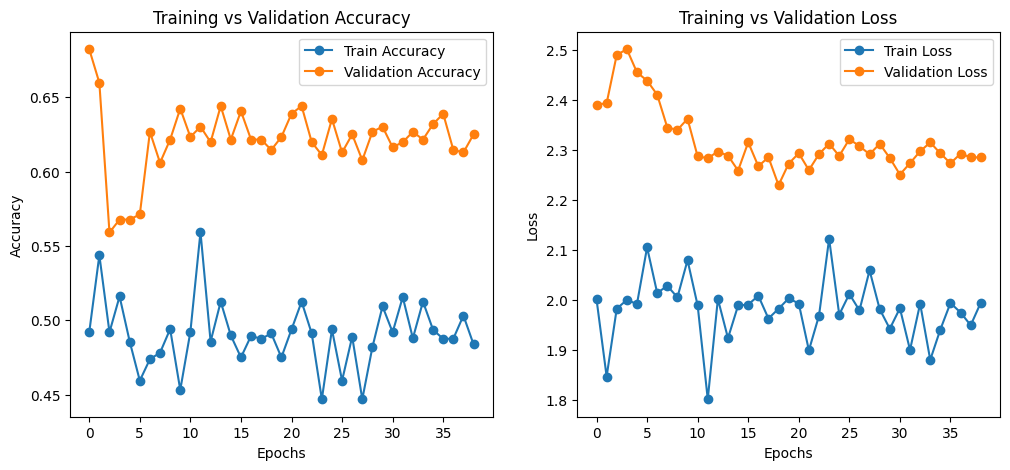

In [ ]:
# Learning rate scheduler
lr = ReduceLROnPlateau(monitor='val_accuracy',
                       patience=2,
                       factor=0.5,
                       verbose=1,
                       min_lr=1e-6)  # Ensures LR doesn’t go too low

# Early stopping to prevent overfitting
es = EarlyStopping(monitor='val_loss',
                   min_delta=0.00001,
                   patience=20,
                   restore_best_weights=True,
                   verbose=1)  # Enabled verbosity

# Model checkpoint to save best model based on validation accuracy
checkpoint = ModelCheckpoint("weights-improvement.keras",
                             monitor="val_accuracy",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

# 🔹 Combine all callbacks
callbacks_list = [checkpoint, lr, es]

# Training parameters
epochs = 60
batch_size = 32

# 🔹 Ensure dataset variables match
history = model.fit(train_generator,
                    steps_per_epoch=x_train_arr.shape[0] // batch_size,
                    validation_data=validation_generator,
                    validation_steps=x_valid_arr.shape[0] // batch_size,
                    epochs=epochs,
                    callbacks=callbacks_list)

# Convert history to DataFrame for easy visualization
hist_ = pd.DataFrame(history.history)

# 🔹 Display training curves
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist_["accuracy"], label="Train Accuracy", marker="o")
plt.plot(hist_["val_accuracy"], label="Validation Accuracy", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(hist_["loss"], label="Train Loss", marker="o")
plt.plot(hist_["val_loss"], label="Validation Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


**Task 2: Model Implementation and Fine-tuning**

**Instructions:**

1. Implement the pre-trained model as described in the research paper.

2. Visualize feature maps of few layers

3. Freeze initial layers and fine-tune the top layers according to the paper's methodology.

4. Optimize hyperparameters such as:

  Learning rate

  Batch size

  Number of epochs

  Optimizer choice (Adam, SGD, RMSprop, etc.)

4. Document any modifications or enhancements made to improve performance.

# VGG 16

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0


Found 4024 images belonging to 37 classes.
Found 1006 images belonging to 37 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 106s 692ms/step - accuracy: 0.0893 - loss: 4.1928 - val_accuracy: 0.0288 - val_loss: 15.9200
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 520ms/step - accuracy: 0.2048 - loss: 3.3097 - val_accuracy: 0.2435 - val_loss: 4.1297
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 516ms/step - accuracy: 0.2815 - loss: 2.7406 - val_accuracy: 0.1859 - val_loss: 3.8852
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 520ms/step - accuracy: 0.3791 - loss: 2.1883 - val_accuracy: 0.0229 - val_loss: 8.3211
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - accuracy: 0.4141 - loss: 1.9952 - val_accuracy: 0.4016 - val_loss: 3.4658
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - accuracy: 0.4505 - loss: 1.7377 - val_accuracy: 0.2147 - val_loss: 3.6309
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 66s 521ms/step - accuracy: 0.4640 - loss: 1.8358 - val_accuracy: 0.2793 - val_loss: 3.7399
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 65s 517ms/step - accuracy: 0.4412 - loss:

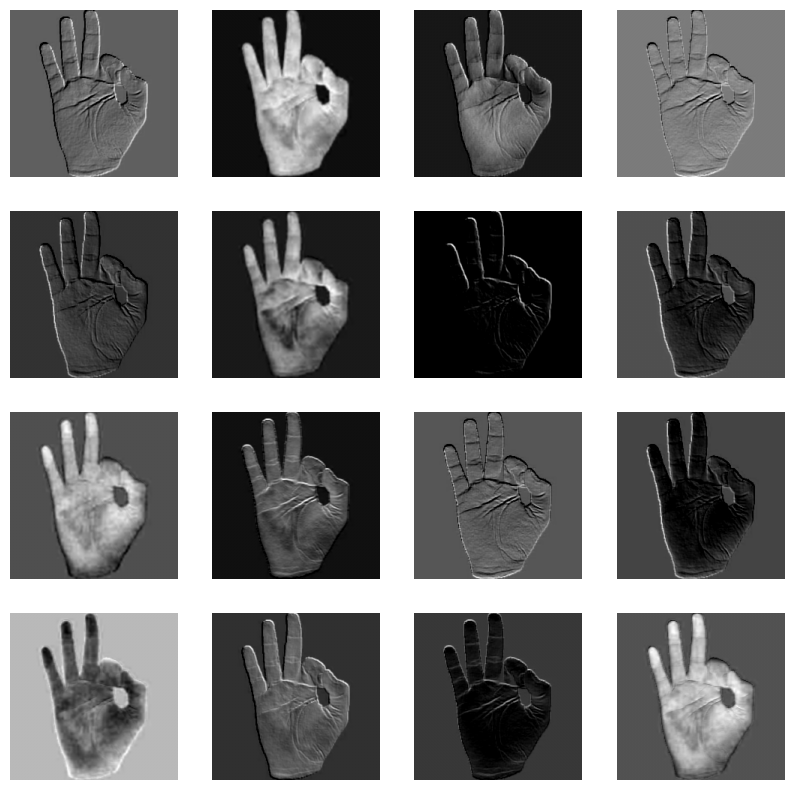

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 48,599,729 (185.39 MB)

 Trainable params: 13,654,309 (52.09 MB)

 Non-trainable params: 7,636,800 (29.13 MB)

 Optimizer params: 27,308,620 (104.17 MB)

In [ ]:


train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),  # Resize images here
    batch_size=32,
    class_mode="categorical",
    subset="training")

validation_generator = train_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),  # Resize images here
    batch_size=32,
    class_mode="categorical",
    subset="validation")

# Load VGG16 model (excluding the top layers)
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))


# Freeze initial layers
for layer in base_model.layers[:15]:
    layer.trainable = False

# Add custom classifier
x = Flatten()(base_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model_vgg16 = Model(inputs=base_model.input, outputs=output)

# Compile model
model_vgg16.compile(optimizer=Adam(learning_rate=0.0003), loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history_vgg16 = model_vgg16.fit(train_generator,
                                validation_data=validation_generator,
                                epochs=10,
                                batch_size=32,
                                verbose=1)

# Feature Map Visualization
layer_outputs = [layer.output for layer in base_model.layers if 'conv' in layer.name]
feature_map_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Load a random image from validation set
img = np.expand_dims(x_valid_arr[0], axis=0)
feature_maps = feature_map_model.predict(img)

# Plot feature maps of first conv layer
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0][0, :, :, i], cmap="gray")
    ax.axis("off")
plt.show()
model_vgg16.summary()

# ResNet 50

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 116s 693ms/step - accuracy: 0.1012 - loss: 4.0268 - val_accuracy: 0.0139 - val_loss: 94.4594
Epoch 2/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 62s 495ms/step - accuracy: 0.4374 - loss: 2.8932 - val_accuracy: 0.0139 - val_loss: 67.4775
Epoch 3/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 497ms/step - accuracy: 0.4485 - loss: 2.6075 - val_accuracy: 0.0179 - val_loss: 21.9217
Epoch 4/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 497ms/step - accuracy: 0.4688 - loss: 2.4704 - val_accuracy: 0.4712 - val_loss: 3.0737
Epoch 5/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 62s 491ms/step - accuracy: 0.4602 - loss: 2.4174 - val_accuracy: 0.4920 - val_loss: 5.3213
Epoch 6/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 63s 496ms/step - accuracy: 0.4686 - loss: 2.3497 - val_accuracy: 0.2266 - val_loss: 7.4171
Epoch 7/8
126/126 ━━━━━━━━━━━━━━━━━━━━ 62s 493ms/step - accuracy: 0.4727 - loss: 2.2571 - val_accuracy: 0.0268 - val_loss: 8.2022
Epoch 8/8
126/126 ━━━━━━━━━━━━━━━━━

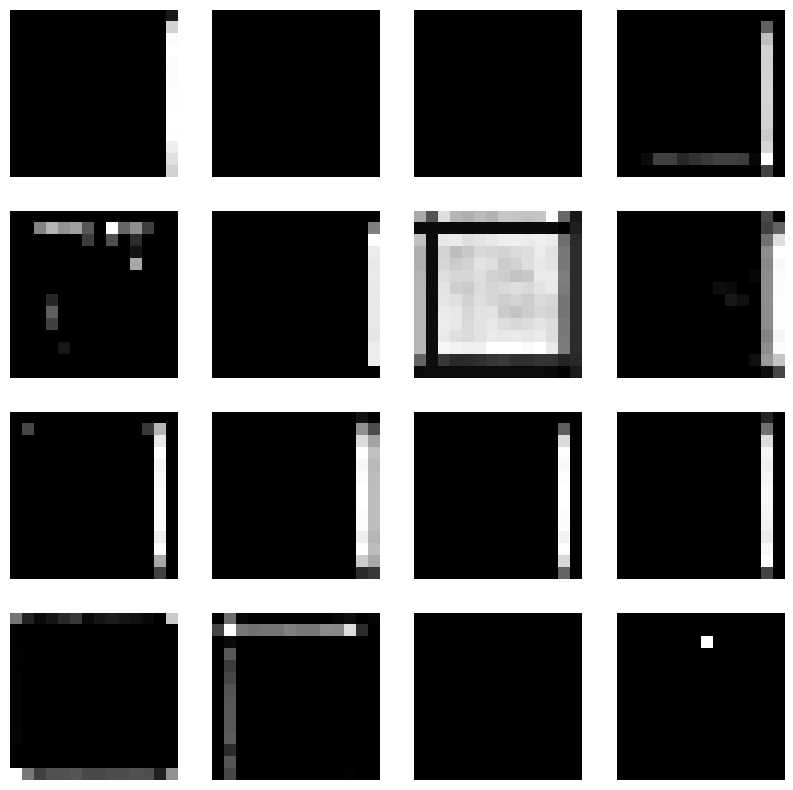

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 45,425,100 (173.28 MB)

 Trainable params: 20,644,389 (78.75 MB)

 Non-trainable params: 4,136,320 (15.78 MB)

 Optimizer params: 20,644,391 (78.75 MB)

In [ ]:

# Load ResNet50 without top layers
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze first 100 layers
for layer in base_model.layers[:100]:
    layer.trainable = False

# Add classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
output = Dense(num_classes, activation="softmax")(x)

model_resnet50 = Model(inputs=base_model.input, outputs=output)

# Compile model
model_resnet50.compile(optimizer="RMSprop", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history_resnet50 = model_resnet50.fit(train_generator,
                                      validation_data=validation_generator,
                                      epochs=8,
                                      batch_size=32,
                                      verbose=1)

# Feature Map Visualization
layer_outputs = [base_model.get_layer("conv4_block3_out").output]  # Example layer

feature_map_model = Model(inputs=base_model.input, outputs=layer_outputs)

# Load a random image from validation set
img = np.expand_dims(x_valid_arr[0], axis=0)
feature_maps = feature_map_model.predict(img)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    ax.imshow(feature_maps[0, :, :,i], cmap="gray")
    ax.axis("off")
plt.show()
model_resnet50.summary()

# EfficientNetB0

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 136s 755ms/step - accuracy: 0.0685 - loss: 4.0864 - val_accuracy: 0.5000 - val_loss: 2.8948
Epoch 2/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 59s 466ms/step - accuracy: 0.2876 - loss: 2.6870 - val_accuracy: 0.5000 - val_loss: 2.7455
Epoch 3/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 59s 465ms/step - accuracy: 0.4149 - loss: 2.0288 - val_accuracy: 0.3310 - val_loss: 3.0006
Epoch 4/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 58s 464ms/step - accuracy: 0.4746 - loss: 1.6505 - val_accuracy: 0.1978 - val_loss: 3.1529
Epoch 5/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 59s 463ms/step - accuracy: 0.4950 - loss: 1.4535 - val_accuracy: 0.1680 - val_loss: 3.4355
Epoch 6/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 58s 463ms/step - accuracy: 0.5253 - loss: 1.3201 - val_accuracy: 0.2137 - val_loss: 2.5202
Epoch 7/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 59s 465ms/step - accuracy: 0.4835 - loss: 1.3038 - val_accuracy: 0.3608 - val_loss: 2.3264
Epoch 8/10
126/126 ━━━━━━━━━━━━━━━━━━━━ 59s 467ms/step - accuracy: 0.5117 - loss: 

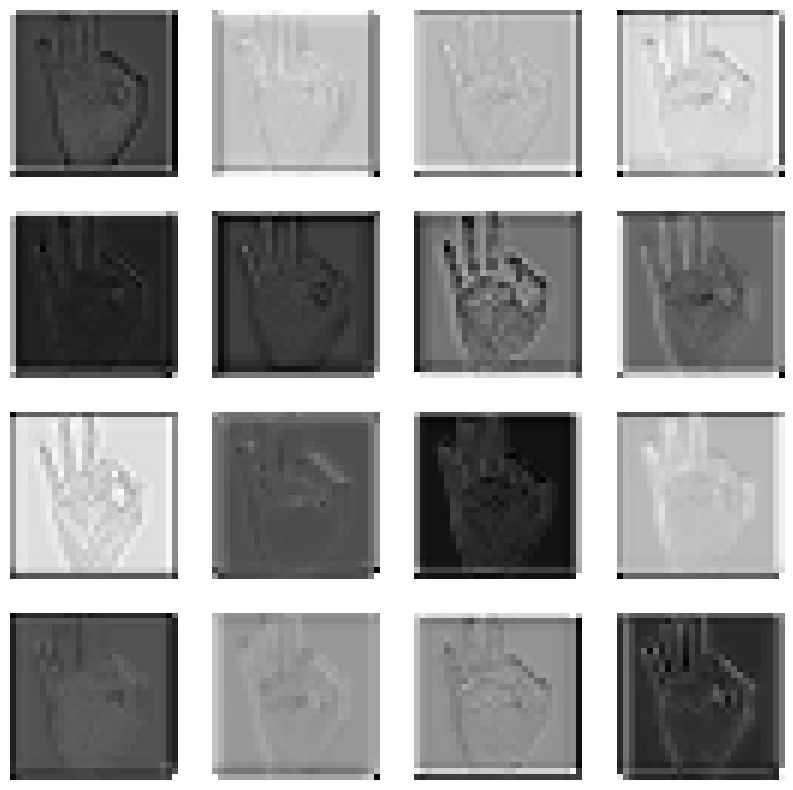

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 4,388,042 (16.74 MB)

 Trainable params: 4,322,671 (16.49 MB)

 Non-trainable params: 65,369 (255.35 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Freeze initial layers
for layer in base_model.layers[:50]:
    layer.trainable = False

# Add custom classifier
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
output = Dense(num_classes, activation="softmax")(x)

model_efficientnet = Model(inputs=base_model.input, outputs=output)

# Compile model
model_efficientnet.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=["accuracy"])

# Train model
history_efficientnet = model_efficientnet.fit(train_generator,
                                              validation_data=validation_generator,
                                              epochs=10,
                                              batch_size=32,
                                              verbose=1)

# Feature Map Visualization
#layer_outputs = [base_model.get_layer("conv4_block3_out").output]  # Example layer
# Choose a valid layer for visualization
layer_name = "block3b_add"  # Change to an existing convolutional layer
selected_layer = base_model.get_layer(layer_name).output

# Create a model to extract feature maps
feature_map_model = Model(inputs=base_model.input, outputs=selected_layer)

# Load and preprocess a random validation image
img = np.expand_dims(x_valid_arr[0], axis=0)
img = preprocess_input(img)  # Ensure proper scaling for EfficientNetB0

# Get feature maps
feature_maps = feature_map_model.predict(img)

# Reshape and visualize feature maps
selected_feature_map = np.squeeze(feature_maps, axis=0)  # Remove batch dimension
num_feature_maps = selected_feature_map.shape[-1]  # Number of feature maps

# Plot at most 16 feature maps
num_plots = min(num_feature_maps, 16)

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat[:num_plots]):
    ax.imshow(selected_feature_map[:, :, i], cmap="gray")
    ax.axis("off")
plt.show()

model_efficientnet.summary()

**Task 3: Model Evaluation and Performance Comparison**

**Instructions:**

1. Evaluate the trained model using performance metrics:

 Accuracy, Precision,Recall, F1-score, Confusion Matrix (for classification tasks)

2. Compare the results with those reported in the research paper.

3. Identify potential weaknesses and suggest improvements.
**Deliverables:**

Performance metrics summary (table or chart).

Graphs/plots showcasing model accuracy and loss trends.

Comparison with research paper results.

Discussion on model performance and areas for improvement.

**Conclusion and Result Visulaization**

32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step

Model: VGG16 Performance Metrics
Accuracy: 0.0924
Precision: 0.2548
Recall: 0.0924
F1-score: 0.1235
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.01      0.29      0.03        14
           2       0.01      0.07      0.02        14
           3       0.00      0.00      0.00        14
           4       0.03      0.07      0.04        14
           5       0.03      0.07      0.04        14
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        14
          11       0.50      0.16      0.24       503
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        14
          14       0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

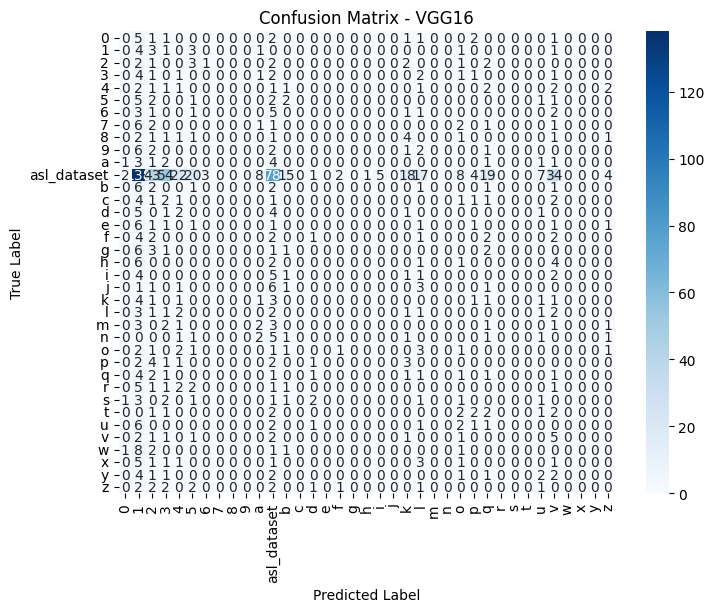

32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 367ms/step

Model: ResNet50 Performance Metrics
Accuracy: 0.0139
Precision: 0.0002
Recall: 0.0139
F1-score: 0.0004
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00        14
           5       0.01      1.00      0.03        14
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        14
           8       0.00      0.00      0.00        14
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        14
          11       0.00      0.00      0.00       503
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        14
          14       0

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

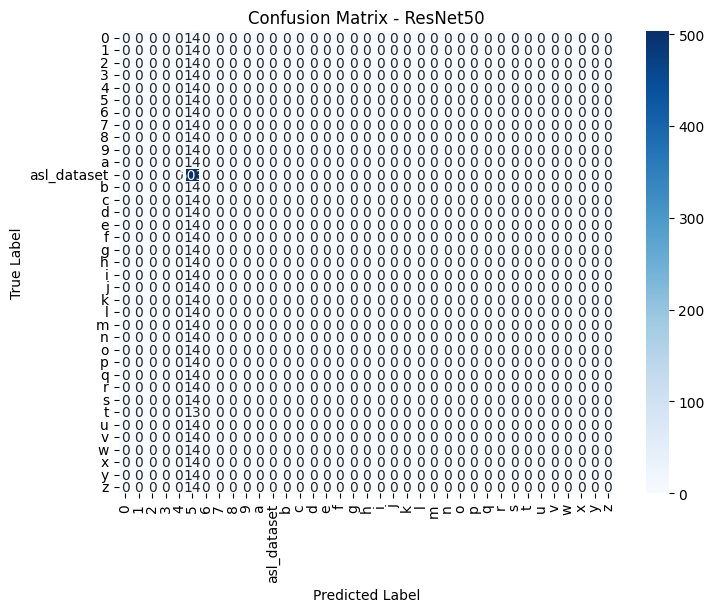

32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 357ms/step

Model: EfficientNetB0 Performance Metrics
Accuracy: 0.2614
Precision: 0.2486
Recall: 0.2614
F1-score: 0.2537
Classification Report:
              precision    recall  f1-score   support

           0       0.02      0.07      0.03        14
           1       0.00      0.00      0.00        14
           2       0.00      0.00      0.00        14
           3       0.00      0.00      0.00        14
           4       0.01      0.07      0.02        14
           5       0.01      0.07      0.02        14
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00        14
           8       0.20      0.07      0.11        14
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        14
          11       0.49      0.51      0.50       503
          12       0.00      0.00      0.00        14
          13       0.00      0.00      0.00        14
          14  

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

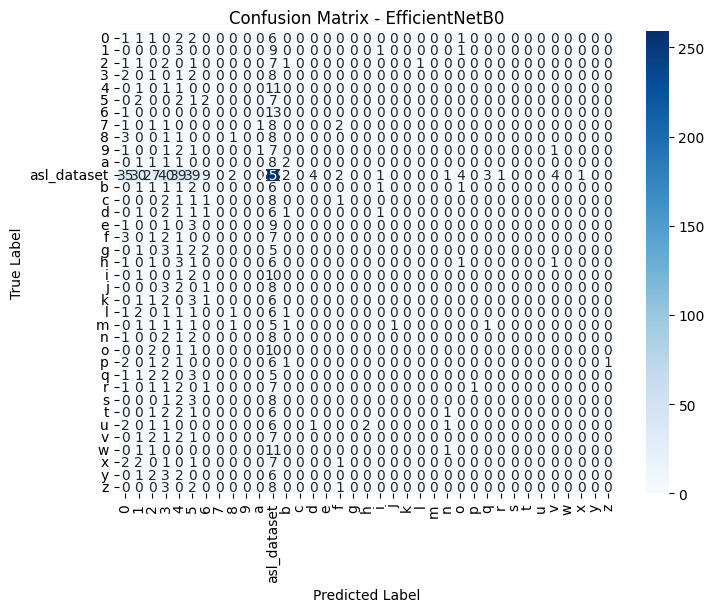


Performance Summary Table:
            Model  Accuracy  Precision    Recall  F1-score
0           VGG16  0.092445   0.254812  0.092445  0.123515
1        ResNet50  0.013917   0.000194  0.013917  0.000382
2  EfficientNetB0  0.261431   0.248640  0.261431  0.253662


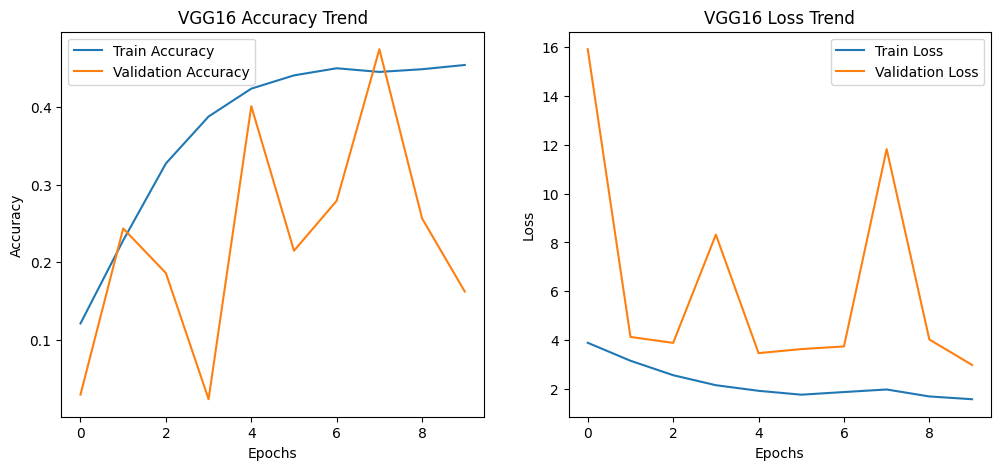

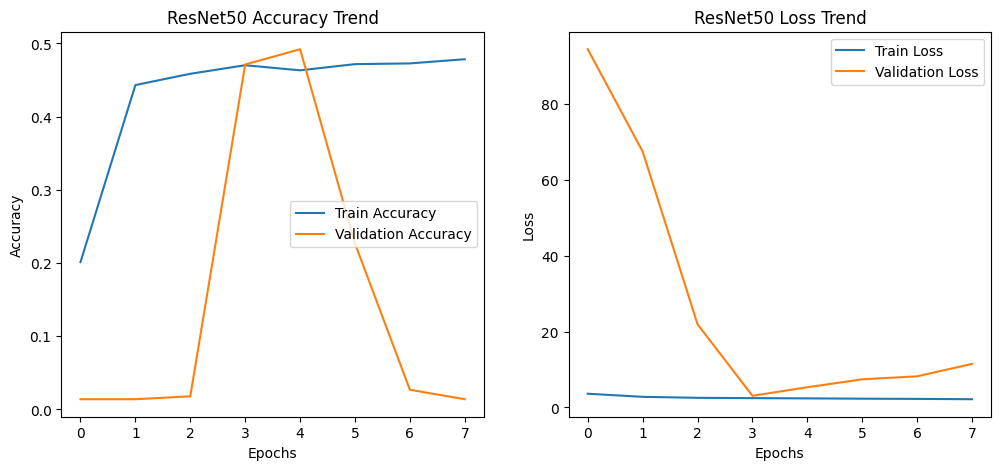

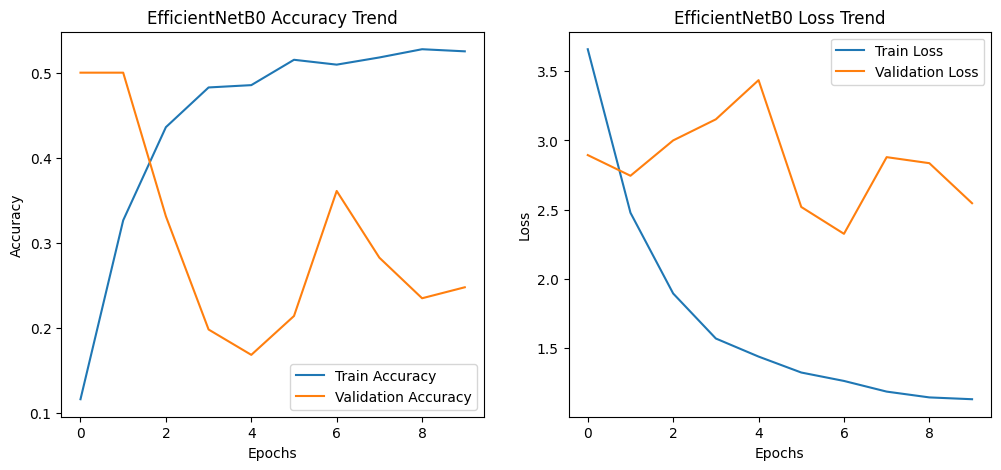

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Get true labels and predictions
def evaluate_model(model, generator, model_name):
    y_true = generator.classes  # True labels
    y_pred = np.argmax(model.predict(generator), axis=1)  # Predicted labels

    # Calculate performance metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    cm = confusion_matrix(y_true, y_pred)

    print(f"\nModel: {model_name} Performance Metrics")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=generator.class_indices, yticklabels=generator.class_indices)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

    return accuracy, precision, recall, f1

# Evaluate all models
vgg16_metrics = evaluate_model(model_vgg16, validation_generator, "VGG16")
resnet50_metrics = evaluate_model(model_resnet50, validation_generator, "ResNet50")
efficientnet_metrics = evaluate_model(model_efficientnet, validation_generator, "EfficientNetB0")

# Create a performance summary table
import pandas as pd

metrics_df = pd.DataFrame({
    "Model": ["VGG16", "ResNet50", "EfficientNetB0"],
    "Accuracy": [vgg16_metrics[0], resnet50_metrics[0], efficientnet_metrics[0]],
    "Precision": [vgg16_metrics[1], resnet50_metrics[1], efficientnet_metrics[1]],
    "Recall": [vgg16_metrics[2], resnet50_metrics[2], efficientnet_metrics[2]],
    "F1-score": [vgg16_metrics[3], resnet50_metrics[3], efficientnet_metrics[3]]
})

print("\nPerformance Summary Table:")
print(metrics_df)

# Plot accuracy & loss trends
def plot_training_history(history, model_name):
    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} Accuracy Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Loss Trend')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Plot trends for each model
plot_training_history(history_vgg16, "VGG16")
plot_training_history(history_resnet50, "ResNet50")
plot_training_history(history_efficientnet, "EfficientNetB0")




**Declaration**

I, Priyanka kadam, confirm that the work submitted in this assignment is my own and has been completed following academic integrity guidelines. The code is uploaded on my GitHub repository account, and the repository link is provided below:

GitHub Repository Link: https://github.com/Priyanka-Kadam427/Deep-Convolutional-Neural-Networks-for-Sign-Language-Recognition

Signature: Priyanka Bhushan Kadam

**Submission Checklist**

✔ Research paper details and summary

✔ Code file (Python Notebook or Script)

✔ Dataset or link to the dataset

✔ Visualizations (if applicable)

✔ Screenshots of model performance metrics

✔ Readme File

✔ Comparison with research paper results